Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
#!git clone https://github.com/google-research/google-research.git

In [2]:
import sys
import os
import tarfile
import urllib
import zipfile

sys.path.append('./google-research')

# Example of model training

Below steps are taken from [model_train_eval](https://github.com/google-research/google-research/blob/master/kws_streaming/train/model_train_eval.py) - it has more tests in streaming, non streaming, quantized and non qunatized models with TF and TFLite.

## Imports

In [3]:
# TF streaming
from kws_streaming.models import models
from kws_streaming.models import utils
from kws_streaming.layers.modes import Modes


2024-02-17 19:48:22.201027: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
import tensorflow as tf
import numpy as np
import tensorflow.compat.v1 as tf1
import logging
from kws_streaming.models import model_params
from kws_streaming.train import model_flags
from kws_streaming.train import test
from kws_streaming.train import train
from kws_streaming.models import utils
from kws_streaming import data
tf1.disable_eager_execution()

In [5]:
config = tf1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf1.Session(config=config)

2024-02-17 19:48:27.589647: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-17 19:48:27.590437: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-17 19:48:27.591400: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-02-17 19:48:27.601496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-17 19:48:27.601638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 

In [6]:
# general imports
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import scipy as scipy
import scipy.io.wavfile as wav
import scipy.signal

In [7]:
tf.__version__

'2.4.0'

In [8]:
tf1.reset_default_graph()
sess = tf1.Session()
tf1.keras.backend.set_session(sess)
tf1.keras.backend.set_learning_phase(0)

2024-02-17 19:48:39.489537: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-17 19:48:39.489701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-17 19:48:39.489833: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 938.86GiB/s
2024-02-17 19:48:39.489852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-02-17 19:48:39.489865: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-02-17 19:48:39.489871: I tensorflow/stream_executor/platfor

## Set path to data

In [9]:
# set PATH to data sets (for example to speech commands V2):
# it can be downloaded from
# https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
# if you already run "00_check-data.ipynb" then folder "data2" should be located in the current dir
current_dir = os.getcwd()
print(current_dir)
DATA_PATH = os.path.join(current_dir, "data2/")
print(DATA_PATH)

/mnt/disk0shared/bdjola/Documents/Technique/DevML/kws_streaming
/mnt/disk0shared/bdjola/Documents/Technique/DevML/kws_streaming/data2/


In [10]:
def waveread_as_pcm16(filename):
  """Read in audio data from a wav file.  Return d, sr."""
  with tf.io.gfile.GFile(filename, 'rb') as file_handle:
    samplerate, wave_data = wav.read(file_handle)
  # Read in wav file.
  return wave_data, samplerate

def wavread_as_float(filename, target_sample_rate=16000):
  """Read in audio data from a wav file.  Return d, sr."""
  wave_data, samplerate = waveread_as_pcm16(filename)
  desired_length = int(
          round(float(len(wave_data)) / samplerate * target_sample_rate))
  wave_data = scipy.signal.resample(wave_data, desired_length)

  # Normalize short ints to floats in range [-1..1).
  data = np.array(wave_data, np.float32) / 32768.0
  return data, target_sample_rate

In [12]:
# Set path to wav file to visualize it
#wav_file = os.path.join(DATA_PATH, "left/0a9f9af7_nohash_0.wav")
#print(wav_file)
# read audio file
#wav_data, samplerate = wavread_as_float(wav_file)

In [14]:
#assert samplerate == 16000

In [15]:
#plt.plot(wav_data)

## Set path to a model with config

In [16]:
# select model name should be one of
model_params.HOTWORD_MODEL_PARAMS.keys()

dict_keys(['svdf', 'svdf_resnet', 'ds_cnn', 'gru', 'lstm', 'cnn_stride', 'cnn', 'tc_resnet', 'crnn', 'dnn', 'att_rnn', 'att_mh_rnn', 'mobilenet', 'mobilenet_v2', 'xception', 'inception', 'inception_resnet', 'ds_tc_resnet'])

In [17]:
MODEL_NAME = 'svdf'
MODELS_PATH = os.path.join(current_dir, "models")
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME + "/")
MODEL_PATH

'/mnt/disk0shared/bdjola/Documents/Technique/DevML/kws_streaming/models/svdf/'

In [18]:
os.makedirs(MODEL_PATH)

FileExistsError: [Errno 17] File exists: '/mnt/disk0shared/bdjola/Documents/Technique/DevML/kws_streaming/models/svdf/'

In [19]:
# get toy model settings
FLAGS = model_params.HOTWORD_MODEL_PARAMS[MODEL_NAME]

In [20]:

# set path to data and model (where model will be stored)
FLAGS.data_dir = DATA_PATH
FLAGS.train_dir = MODEL_PATH

# set speech feature extractor properties
FLAGS.mel_upper_edge_hertz = 7000
FLAGS.window_size_ms = 40.0
FLAGS.window_stride_ms = 20.0
FLAGS.mel_num_bins = 80
FLAGS.dct_num_features = 40
FLAGS.feature_type = 'mfcc_op'
FLAGS.preprocess = 'raw'

# set training settings
FLAGS.train = 1
#FLAGS.how_many_training_steps = '400,400,400,400'  # reduced number of training steps for test only
#FLAGS.learning_rate = '0.001,0.0005,0.0001,0.00002'

FLAGS.how_many_training_steps = '1000,1000,1000,1000,1000'  # reduced number of training steps for test only
FLAGS.learning_rate = '0.001,0.0005,0.0001,0.00002,0.000004'

FLAGS.lr_schedule = 'linear'
FLAGS.verbosity = logging.INFO

# data shuffling config
FLAGS.resample = 0.15
FLAGS.time_shift_ms = 100

In [21]:
# model parameters are different for every model
FLAGS.model_name = MODEL_NAME
FLAGS.svdf_memory_size = "4,10,10,10,10,10"
FLAGS.svdf_units1 = "16,32,32,32,64,128"
FLAGS.svdf_act = "'relu','relu','relu','relu','relu','relu'"
FLAGS.svdf_units2 = "40,40,64,64,64,-1"
FLAGS.svdf_dropout = "0.0,0.0,0.0,0.0,0.0,0.0"
FLAGS.svdf_pad = 0
FLAGS.dropout1 = 0.0
FLAGS.units2 = ''
FLAGS.act2 = ''

In [22]:
flags = model_flags.update_flags(FLAGS)

In [23]:
flags.__dict__

{'data_url': '',
 'train_dir': '/mnt/disk0shared/bdjola/Documents/Technique/DevML/kws_streaming/models/svdf/',
 'wanted_words': 'yes,no,up,down,left,right,on,off,stop,go',
 'train': 1,
 'split_data': 1,
 'sample_rate': 16000,
 'clip_duration_ms': 1000,
 'window_size_ms': 40.0,
 'window_stride_ms': 20.0,
 'preprocess': 'raw',
 'feature_type': 'mfcc_op',
 'preemph': 0.0,
 'window_type': 'hann',
 'mel_num_bins': 80,
 'mel_lower_edge_hertz': 20.0,
 'mel_upper_edge_hertz': 7000,
 'log_epsilon': 1e-12,
 'dct_num_features': 40,
 'use_tf_fft': 0,
 'mel_non_zero_only': 1,
 'fft_magnitude_squared': False,
 'use_spec_augment': 0,
 'time_masks_number': 2,
 'time_mask_max_size': 10,
 'frequency_masks_number': 2,
 'frequency_mask_max_size': 5,
 'use_spec_cutout': 0,
 'spec_cutout_masks_number': 3,
 'spec_cutout_time_mask_size': 10,
 'spec_cutout_frequency_mask_size': 5,
 'optimizer': 'adam',
 'lr_schedule': 'linear',
 'background_volume': 0.1,
 'l2_weight_decay': 0.0,
 'background_frequency': 0.8,
 

In [24]:
with open(os.path.join(flags.train_dir, 'flags.json'), 'wt') as f:
  json.dump(flags.__dict__, f)

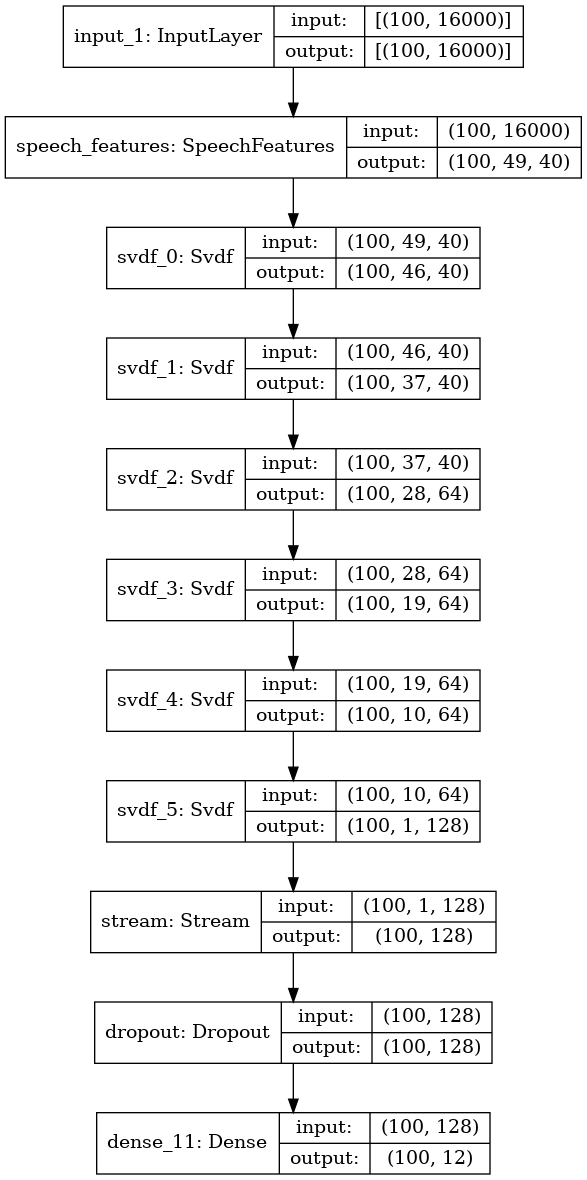

In [25]:
# visualize a model
model_non_stream_batch = models.MODELS[flags.model_name](flags)
tf.keras.utils.plot_model(
    model_non_stream_batch,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [26]:
model_non_stream_batch.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(100, 16000)]            0         
_________________________________________________________________
speech_features (SpeechFeatu (100, 49, 40)             0         
_________________________________________________________________
svdf_0 (Svdf)                (100, 46, 40)             1400      
_________________________________________________________________
svdf_1 (Svdf)                (100, 37, 40)             2952      
_________________________________________________________________
svdf_2 (Svdf)                (100, 28, 64)             3744      
_________________________________________________________________
svdf_3 (Svdf)                (100, 19, 64)             4512      
_________________________________________________________________
svdf_4 (Svdf)                (100, 10, 64)             8960  

## Model training

In [27]:
# Model training
train.train(flags)

2024-02-17 19:52:13.691951: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-17 19:52:13.692137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-17 19:52:13.692294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 938.86GiB/s
2024-02-17 19:52:13.692318: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-02-17 19:52:13.692333: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-02-17 19:52:13.692339: I tensorflow/stream_executor/platfor

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(100, 16000)]            0         
_________________________________________________________________
speech_features (SpeechFeatu (100, 49, 40)             0         
_________________________________________________________________
svdf_0 (Svdf)                (100, 46, 40)             1400      
_________________________________________________________________
svdf_1 (Svdf)                (100, 37, 40)             2952      
_________________________________________________________________
svdf_2 (Svdf)                (100, 28, 64)             3744      
_________________________________________________________________
svdf_3 (Svdf)                (100, 19, 64)             4512      
_________________________________________________________________
svdf_4 (Svdf)                (100, 10, 64)             8960  

INFO:absl:Step #1: rate 0.001000, accuracy 9.00%, cross entropy 2.483776
INFO:absl:Step #2: rate 0.001000, accuracy 10.00%, cross entropy 2.485426
INFO:absl:Step #3: rate 0.001000, accuracy 16.00%, cross entropy 2.475225
INFO:absl:Step #4: rate 0.001000, accuracy 9.00%, cross entropy 2.456486
INFO:absl:Step #5: rate 0.001000, accuracy 12.00%, cross entropy 2.449385
INFO:absl:Step #6: rate 0.001000, accuracy 7.00%, cross entropy 2.466619
INFO:absl:Step #7: rate 0.001000, accuracy 14.00%, cross entropy 2.433821
INFO:absl:Step #8: rate 0.001000, accuracy 10.00%, cross entropy 2.483710
INFO:absl:Step #9: rate 0.001000, accuracy 6.00%, cross entropy 2.491015
INFO:absl:Step #10: rate 0.001000, accuracy 14.00%, cross entropy 2.436279
INFO:absl:Step #11: rate 0.001000, accuracy 14.00%, cross entropy 2.354695
INFO:absl:Step #12: rate 0.001000, accuracy 8.00%, cross entropy 2.416662
INFO:absl:Step #13: rate 0.001000, accuracy 15.00%, cross entropy 2.395719
INFO:absl:Step #14: rate 0.001000, accu

## Run model evaluation

### TF Run non streaming inference

In [28]:
folder_name = 'tf'
test.tf_non_stream_model_accuracy(flags, folder_name)

2024-02-17 20:04:31.846673: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-17 20:04:31.846845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-17 20:04:31.846990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 938.86GiB/s
2024-02-17 20:04:31.847011: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-02-17 20:04:31.847025: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-02-17 20:04:31.847032: I tensorflow/stream_executor/platfor

78.72916666666666

more testing functions can be found at [test](https://github.com/google-research/google-research/blob/master/kws_streaming/train/test.py)

In [29]:
print(flags.__dict__)

{'data_url': '', 'train_dir': '/mnt/disk0shared/bdjola/Documents/Technique/DevML/kws_streaming/models/svdf/', 'wanted_words': 'yes,no,up,down,left,right,on,off,stop,go', 'train': 1, 'split_data': 1, 'sample_rate': 16000, 'clip_duration_ms': 1000, 'window_size_ms': 40.0, 'window_stride_ms': 20.0, 'preprocess': 'raw', 'feature_type': 'mfcc_op', 'preemph': 0.0, 'window_type': 'hann', 'mel_num_bins': 80, 'mel_lower_edge_hertz': 20.0, 'mel_upper_edge_hertz': 7000, 'log_epsilon': 1e-12, 'dct_num_features': 40, 'use_tf_fft': 0, 'mel_non_zero_only': 1, 'fft_magnitude_squared': False, 'use_spec_augment': 0, 'time_masks_number': 2, 'time_mask_max_size': 10, 'frequency_masks_number': 2, 'frequency_mask_max_size': 5, 'use_spec_cutout': 0, 'spec_cutout_masks_number': 3, 'spec_cutout_time_mask_size': 10, 'spec_cutout_frequency_mask_size': 5, 'optimizer': 'adam', 'lr_schedule': 'linear', 'background_volume': 0.1, 'l2_weight_decay': 0.0, 'background_frequency': 0.8, 'silence_percentage': 10.0, 'unknow